## Predicting personality type using machine learning

The database we are working with classifies people into 16 distinct personality types showing their comment on social media.

Our goal will be to create new columns based on the content of the tweets, in order to create a predictive model. As we will see, this can be quite tricky and our creativity comes into play when analysing the content of the tweets.

We begin by importing our dataset and showing some info, for an initial exploratory analysis

### Import required libraries

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno
import re

# Text preprocessing
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer, RegexpStemmer, LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import string

# Machine learning packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# evaluation metrics
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay,confusion_matrix, classification_report, accuracy_score
from wordcloud import WordCloud, STOPWORDS
from imblearn.over_sampling import SMOTE, RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

### Read Data

In [28]:
# read dataset
personality_data = pd.read_csv('mbti_1.csv')
personality_data

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [29]:
# check the unique type
personality_data.type.unique()

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

AxesSubplot(0.125,0.125;0.698618x0.755)


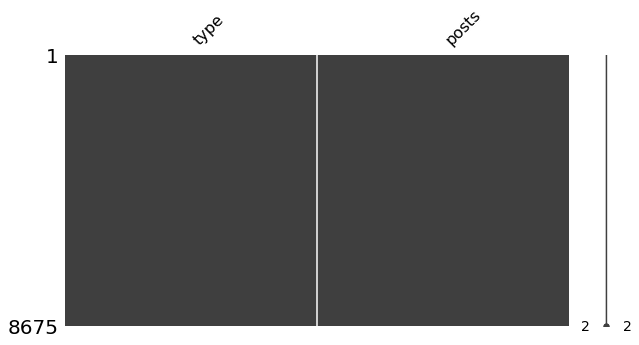

In [4]:
# A function to check for missing data
def missingNumber(df):
    graph = missingno.matrix(df, figsize=(10, 5))
    return graph
    
print(missingNumber(personality_data))

In [5]:
# Checking the structure of the data
def dataInfo(df):
    return df.info()

print(dataInfo(personality_data))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB
None


In [6]:
# print the shape of the dataset
nRow, nCol = personality_data.shape
print(f'There are {nRow} rows and {nCol} columns in the dataset')

There are 8675 rows and 2 columns in the dataset


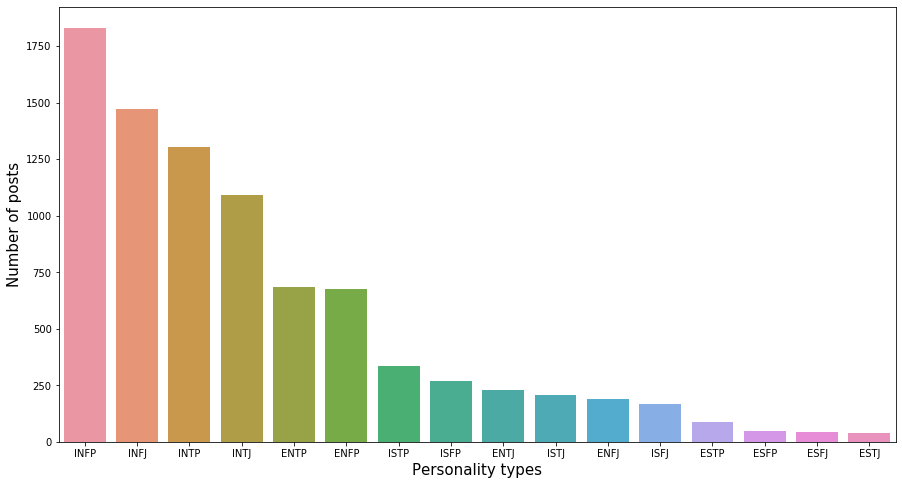

In [7]:
# view the type column 
data = personality_data.type.value_counts()
plt.figure(figsize=(15,8))
plt.xlabel("Personality types", fontsize=15)
plt.ylabel('Number of posts', fontsize=15)
sns.barplot(data.index, data.values)

The plot shows that the dataset is imbalanced across all personality types. We can conclude a lot of people who commewnt on social media are introverted, sensitive, innovative, and makes decision based on logical reasoning

In [8]:
# checking the most common personality type
df = personality_data.describe(include='object')
df

,type,posts
count,8675,8675
unique,16,8675
top,INFP,"'There wasn't really a subforum for music, so ..."
freq,1832,1


The table conforms that INFP is the most common word occurring in the data.

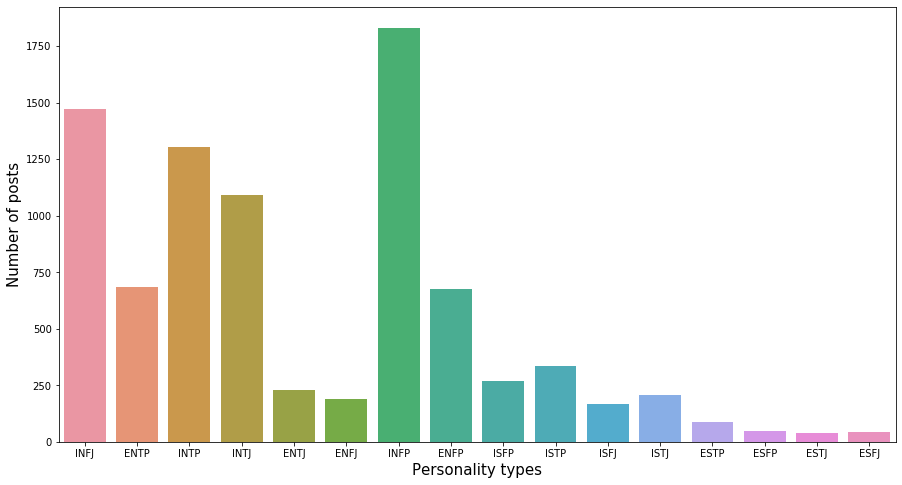

In [9]:
plt.figure(figsize=(15,8))
sns.countplot(x='type', data=personality_data)
plt.xlabel("Personality types", fontsize=15)
plt.ylabel('Number of posts', fontsize=15)
plt.show()

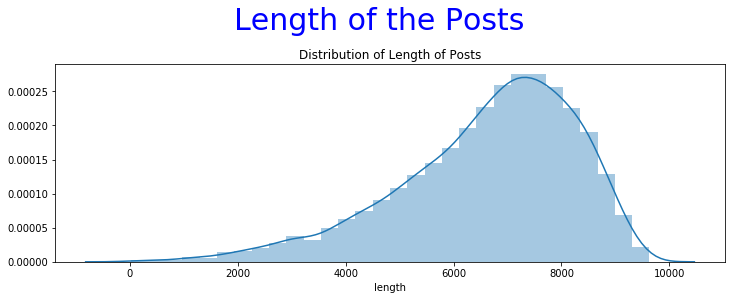

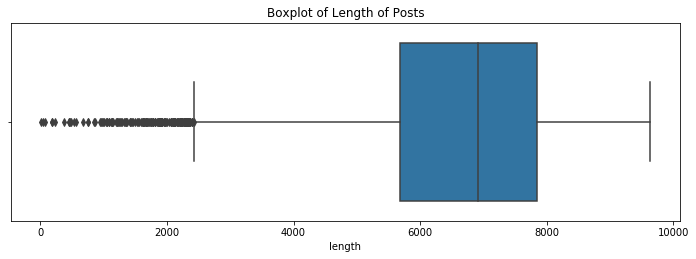

In [11]:
# Length of the text
plt.figure(figsize = (12,8))
plt.subplot(2,1,1)
personality_data['length'] = personality_data.posts.apply(lambda x:len(x))
plt.suptitle('Length of the Posts',fontsize = 30 , color = 'blue')
sns.distplot(personality_data.length , kde=True , bins = 30 ).set(title = 'Distribution of Length of Posts')
plt.figure(figsize = (12,8))
plt.subplot(2,1,2)
sns.boxplot(personality_data.length).set(title = 'Boxplot of Length of Posts')
plt.show()

### Quick Analysis


In [8]:
personality_data['question_per_comment'] = personality_data['posts'].apply(lambda x: x.count('?'))
personality_data['link_per_comment'] = personality_data['posts'].apply(lambda x: x.count('http'))
personality_data['length_of_comment'] = personality_data['posts'].apply(lambda x: len(x))
personality_data

,type,posts,question_per_comment,link_per_comment,length_of_comment
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,18,24,4652
1,ENTP,'I'm finding the lack of me in these posts ver...,5,10,7053
2,INTP,'Good one _____ https://www.youtube.com/wat...,12,5,5265
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",11,2,6271
4,ENTJ,'You're fired.|||That's another silly misconce...,10,6,6111
...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,9,7,5011
8671,ENFP,'So...if this thread already exists someplace ...,10,2,7902
8672,INTP,'So many questions when i do these things. I ...,9,2,5772
8673,INFP,'I am very conflicted right now when it comes ...,9,0,9479


### Text Preprocessing 
1. Lowercase text
2. Remove whitespace
3. Remove numbers
4. Remove special characters
5. Remove emails
6. Remove stop words
7. Remove MBTI profile strings from the posts
8. Remove weblinks
9. Expand contractions (if possible not necessary)
10. Tokenize
11. Lemmatise

#### Convert words to lowercase

In [30]:
def lower(text):
    text = text.lower()
    return text

personality_data['posts'] = personality_data['posts'].apply(lower)
personality_data

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsxhcwe3krw|||...
1,ENTP,'i'm finding the lack of me in these posts ver...
2,INTP,'good one _____ https://www.youtube.com/wat...
3,INTJ,"'dear intp, i enjoyed our conversation the o..."
4,ENTJ,'you're fired.|||that's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edhb_h908||...
8671,ENFP,'so...if this thread already exists someplace ...
8672,INTP,'so many questions when i do these things. i ...
8673,INFP,'i am very conflicted right now when it comes ...


#### Remove links 

In [31]:
def remove_links(text):
    text =  sentence = re.sub(r"http\S+", ' ', text)
    return text

personality_data['posts'] = personality_data['posts'].apply(remove_links)
personality_data

,type,posts
0,INFJ,' and intj moments sportscenter not top t...
1,ENTP,'i'm finding the lack of me in these posts ver...
2,INTP,"'good one _____ course, to which i say i ..."
3,INTJ,"'dear intp, i enjoyed our conversation the o..."
4,ENTJ,'you're fired.|||that's another silly misconce...
...,...,...
8670,ISFP,' just because i always think of cats as fi d...
8671,ENFP,'so...if this thread already exists someplace ...
8672,INTP,'so many questions when i do these things. i ...
8673,INFP,'i am very conflicted right now when it comes ...


#### Remove special characters

Removing characters that are not alphabetical order.

In [32]:
def remove_non_words(text):
    text = re.sub('[^0-9a-z]+', ' ', text)
    return text
    
personality_data['posts'] = personality_data['posts'].apply(remove_non_words)
personality_data

,type,posts
0,INFJ,and intj moments sportscenter not top ten pla...
1,ENTP,i m finding the lack of me in these posts ver...
2,INTP,good one course to which i say i know that s ...
3,INTJ,dear intp i enjoyed our conversation the othe...
4,ENTJ,you re fired that s another silly misconcepti...
...,...,...
8670,ISFP,just because i always think of cats as fi dom...
8671,ENFP,so if this thread already exists someplace el...
8672,INTP,so many questions when i do these things i wo...
8673,INFP,i am very conflicted right now when it comes ...


#### Remove the digits

In [33]:
# remove the digits
def remove_digits(text):
    text = re.sub(r'\d+', '', text)
    return text

personality_data['posts'] = personality_data['posts'].apply(remove_digits)
personality_data

,type,posts
0,INFJ,and intj moments sportscenter not top ten pla...
1,ENTP,i m finding the lack of me in these posts ver...
2,INTP,good one course to which i say i know that s ...
3,INTJ,dear intp i enjoyed our conversation the othe...
4,ENTJ,you re fired that s another silly misconcepti...
...,...,...
8670,ISFP,just because i always think of cats as fi dom...
8671,ENFP,so if this thread already exists someplace el...
8672,INTP,so many questions when i do these things i wo...
8673,INFP,i am very conflicted right now when it comes ...


#### Remove personality type from the posts

In [34]:
def remove_mbti(text):
    personality_type_unique = personality_data.type.unique()
    personality_type_unique = [type.lower() for type in personality_type_unique]
    personality = '|'.join(personality_type_unique)
    text = re.sub(personality, '', text)
    return text

personality_data['posts'] = personality_data['posts'].apply(remove_mbti)
personality_data

,type,posts
0,INFJ,and moments sportscenter not top ten plays p...
1,ENTP,i m finding the lack of me in these posts ver...
2,INTP,good one course to which i say i know that s ...
3,INTJ,dear i enjoyed our conversation the other da...
4,ENTJ,you re fired that s another silly misconcepti...
...,...,...
8670,ISFP,just because i always think of cats as fi dom...
8671,ENFP,so if this thread already exists someplace el...
8672,INTP,so many questions when i do these things i wo...
8673,INFP,i am very conflicted right now when it comes ...


#### Tokenizing
Tokenizing is one of the important technique in text preprocessing. It divides text or document into smaller chunks known as tokens.

In [35]:
def tokenize(text):
    word = word_tokenize(text)
    return word


personality_data['token_post'] = personality_data['posts'].apply(tokenize)
personality_data

,type,posts,token_post
0,INFJ,and moments sportscenter not top ten plays p...,"[and, moments, sportscenter, not, top, ten, pl..."
1,ENTP,i m finding the lack of me in these posts ver...,"[i, m, finding, the, lack, of, me, in, these, ..."
2,INTP,good one course to which i say i know that s ...,"[good, one, course, to, which, i, say, i, know..."
3,INTJ,dear i enjoyed our conversation the other da...,"[dear, i, enjoyed, our, conversation, the, oth..."
4,ENTJ,you re fired that s another silly misconcepti...,"[you, re, fired, that, s, another, silly, misc..."
...,...,...,...
8670,ISFP,just because i always think of cats as fi dom...,"[just, because, i, always, think, of, cats, as..."
8671,ENFP,so if this thread already exists someplace el...,"[so, if, this, thread, already, exists, somepl..."
8672,INTP,so many questions when i do these things i wo...,"[so, many, questions, when, i, do, these, thin..."
8673,INFP,i am very conflicted right now when it comes ...,"[i, am, very, conflicted, right, now, when, it..."


#### Remove Stopwords

Stopwords are words that are irrelevant in English Language that often occur in text. They don't tell much about data hence, we need to remove them

In [36]:
stop_words = set(STOPWORDS)
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stop_words]
    return text

personality_data['no_stopwords'] = personality_data['token_post'].apply(lambda x: remove_stopwords(x))
personality_data

,type,posts,token_post,no_stopwords
0,INFJ,and moments sportscenter not top ten plays p...,"[and, moments, sportscenter, not, top, ten, pl...","[moments, sportscenter, top, ten, plays, prank..."
1,ENTP,i m finding the lack of me in these posts ver...,"[i, m, finding, the, lack, of, me, in, these, ...","[m, finding, lack, posts, alarming, sex, borin..."
2,INTP,good one course to which i say i know that s ...,"[good, one, course, to, which, i, say, i, know...","[good, one, course, say, know, s, blessing, cu..."
3,INTJ,dear i enjoyed our conversation the other da...,"[dear, i, enjoyed, our, conversation, the, oth...","[dear, enjoyed, conversation, day, esoteric, g..."
4,ENTJ,you re fired that s another silly misconcepti...,"[you, re, fired, that, s, another, silly, misc...","[re, fired, s, another, silly, misconception, ..."
...,...,...,...,...
8670,ISFP,just because i always think of cats as fi dom...,"[just, because, i, always, think, of, cats, as...","[always, think, cats, fi, doms, reason, websit..."
8671,ENFP,so if this thread already exists someplace el...,"[so, if, this, thread, already, exists, somepl...","[thread, already, exists, someplace, heck, del..."
8672,INTP,so many questions when i do these things i wo...,"[so, many, questions, when, i, do, these, thin...","[many, questions, things, take, purple, pill, ..."
8673,INFP,i am very conflicted right now when it comes ...,"[i, am, very, conflicted, right, now, when, it...","[conflicted, right, now, comes, wanting, child..."


### Stemming 
Stemming helps reduce a word to its stem form. It often makes sense to treat related words in the same way. It removes suffices, like “ing”, “ly”, “s”, etc. by a simple rule-based approach. It reduces the corpus of words but often the actual words get neglected. eg: Entitling,Entitled->Entitl
Note: Some search engines treat words with the same stem as synonyms.

In [37]:
st = PorterStemmer()
def stemming(tokenized_list):
    token = [st.stem(word) for word in tokenized_list]
    return token

personality_data['stem'] = personality_data['no_stopwords'].apply(lambda x: stemming(x))
personality_data

,type,posts,token_post,no_stopwords,stem
0,INFJ,and moments sportscenter not top ten plays p...,"[and, moments, sportscenter, not, top, ten, pl...","[moments, sportscenter, top, ten, plays, prank...","[moment, sportscent, top, ten, play, prank, li..."
1,ENTP,i m finding the lack of me in these posts ver...,"[i, m, finding, the, lack, of, me, in, these, ...","[m, finding, lack, posts, alarming, sex, borin...","[m, find, lack, post, alarm, sex, bore, s, pos..."
2,INTP,good one course to which i say i know that s ...,"[good, one, course, to, which, i, say, i, know...","[good, one, course, say, know, s, blessing, cu...","[good, one, cours, say, know, s, bless, curs, ..."
3,INTJ,dear i enjoyed our conversation the other da...,"[dear, i, enjoyed, our, conversation, the, oth...","[dear, enjoyed, conversation, day, esoteric, g...","[dear, enjoy, convers, day, esoter, gab, natur..."
4,ENTJ,you re fired that s another silly misconcepti...,"[you, re, fired, that, s, another, silly, misc...","[re, fired, s, another, silly, misconception, ...","[re, fire, s, anoth, silli, misconcept, approa..."
...,...,...,...,...,...
8670,ISFP,just because i always think of cats as fi dom...,"[just, because, i, always, think, of, cats, as...","[always, think, cats, fi, doms, reason, websit...","[alway, think, cat, fi, dom, reason, websit, b..."
8671,ENFP,so if this thread already exists someplace el...,"[so, if, this, thread, already, exists, somepl...","[thread, already, exists, someplace, heck, del...","[thread, alreadi, exist, someplac, heck, delet..."
8672,INTP,so many questions when i do these things i wo...,"[so, many, questions, when, i, do, these, thin...","[many, questions, things, take, purple, pill, ...","[mani, question, thing, take, purpl, pill, pic..."
8673,INFP,i am very conflicted right now when it comes ...,"[i, am, very, conflicted, right, now, when, it...","[conflicted, right, now, comes, wanting, child...","[conflict, right, now, come, want, children, h..."


### Lemmatization
Lemmatizing reduces word into its root form. It is better than stemming as it gives a morpholigical meaning to the word. The only difference between stemming and lemmatization is that lemmatization is preferred when the meaning of the word is important. However, stemming is faster because it chops off the end of the word without understanding the context. 

In [39]:
lem = WordNetLemmatizer()
def lemmatizing(tokenized_list):
    token = [lem.lemmatize(word) for word in tokenized_list]
    return token

personality_data['lemmatize_word'] = personality_data['no_stopwords'].apply(lambda x: lemmatizing(x))
personality_data

,type,posts,token_post,no_stopwords,stem,lemmatize_word
0,INFJ,and moments sportscenter not top ten plays p...,"[and, moments, sportscenter, not, top, ten, pl...","[moments, sportscenter, top, ten, plays, prank...","[moment, sportscenter, top, ten, play, prank, ...","[moment, sportscenter, top, ten, play, prank, ..."
1,ENTP,i m finding the lack of me in these posts ver...,"[i, m, finding, the, lack, of, me, in, these, ...","[m, finding, lack, posts, alarming, sex, borin...","[m, finding, lack, post, alarming, sex, boring...","[m, finding, lack, post, alarming, sex, boring..."
2,INTP,good one course to which i say i know that s ...,"[good, one, course, to, which, i, say, i, know...","[good, one, course, say, know, s, blessing, cu...","[good, one, course, say, know, s, blessing, cu...","[good, one, course, say, know, s, blessing, cu..."
3,INTJ,dear i enjoyed our conversation the other da...,"[dear, i, enjoyed, our, conversation, the, oth...","[dear, enjoyed, conversation, day, esoteric, g...","[dear, enjoyed, conversation, day, esoteric, g...","[dear, enjoyed, conversation, day, esoteric, g..."
4,ENTJ,you re fired that s another silly misconcepti...,"[you, re, fired, that, s, another, silly, misc...","[re, fired, s, another, silly, misconception, ...","[re, fired, s, another, silly, misconception, ...","[re, fired, s, another, silly, misconception, ..."
...,...,...,...,...,...,...
8670,ISFP,just because i always think of cats as fi dom...,"[just, because, i, always, think, of, cats, as...","[always, think, cats, fi, doms, reason, websit...","[always, think, cat, fi, doms, reason, website...","[always, think, cat, fi, doms, reason, website..."
8671,ENFP,so if this thread already exists someplace el...,"[so, if, this, thread, already, exists, somepl...","[thread, already, exists, someplace, heck, del...","[thread, already, exists, someplace, heck, del...","[thread, already, exists, someplace, heck, del..."
8672,INTP,so many questions when i do these things i wo...,"[so, many, questions, when, i, do, these, thin...","[many, questions, things, take, purple, pill, ...","[many, question, thing, take, purple, pill, pi...","[many, question, thing, take, purple, pill, pi..."
8673,INFP,i am very conflicted right now when it comes ...,"[i, am, very, conflicted, right, now, when, it...","[conflicted, right, now, comes, wanting, child...","[conflicted, right, now, come, wanting, child,...","[conflicted, right, now, come, wanting, child,..."


In [40]:
## combine text
def combine(text):
    return ' '.join(text)

personality_data['clean_posts'] = personality_data['lemmatize_word'].apply(combine)
personality_data

,type,posts,token_post,no_stopwords,stem,lemmatize_word,clean_posts
0,INFJ,and moments sportscenter not top ten plays p...,"[and, moments, sportscenter, not, top, ten, pl...","[moments, sportscenter, top, ten, plays, prank...","[moment, sportscenter, top, ten, play, prank, ...","[moment, sportscenter, top, ten, play, prank, ...",moment sportscenter top ten play prank life ch...
1,ENTP,i m finding the lack of me in these posts ver...,"[i, m, finding, the, lack, of, me, in, these, ...","[m, finding, lack, posts, alarming, sex, borin...","[m, finding, lack, post, alarming, sex, boring...","[m, finding, lack, post, alarming, sex, boring...",m finding lack post alarming sex boring s posi...
2,INTP,good one course to which i say i know that s ...,"[good, one, course, to, which, i, say, i, know...","[good, one, course, say, know, s, blessing, cu...","[good, one, course, say, know, s, blessing, cu...","[good, one, course, say, know, s, blessing, cu...",good one course say know s blessing curse abso...
3,INTJ,dear i enjoyed our conversation the other da...,"[dear, i, enjoyed, our, conversation, the, oth...","[dear, enjoyed, conversation, day, esoteric, g...","[dear, enjoyed, conversation, day, esoteric, g...","[dear, enjoyed, conversation, day, esoteric, g...",dear enjoyed conversation day esoteric gabbing...
4,ENTJ,you re fired that s another silly misconcepti...,"[you, re, fired, that, s, another, silly, misc...","[re, fired, s, another, silly, misconception, ...","[re, fired, s, another, silly, misconception, ...","[re, fired, s, another, silly, misconception, ...",re fired s another silly misconception approac...
...,...,...,...,...,...,...,...
8670,ISFP,just because i always think of cats as fi dom...,"[just, because, i, always, think, of, cats, as...","[always, think, cats, fi, doms, reason, websit...","[always, think, cat, fi, doms, reason, website...","[always, think, cat, fi, doms, reason, website...",always think cat fi doms reason website become...
8671,ENFP,so if this thread already exists someplace el...,"[so, if, this, thread, already, exists, somepl...","[thread, already, exists, someplace, heck, del...","[thread, already, exists, someplace, heck, del...","[thread, already, exists, someplace, heck, del...",thread already exists someplace heck delete on...
8672,INTP,so many questions when i do these things i wo...,"[so, many, questions, when, i, do, these, thin...","[many, questions, things, take, purple, pill, ...","[many, question, thing, take, purple, pill, pi...","[many, question, thing, take, purple, pill, pi...",many question thing take purple pill pick winn...
8673,INFP,i am very conflicted right now when it comes ...,"[i, am, very, conflicted, right, now, when, it...","[conflicted, right, now, comes, wanting, child...","[conflicted, right, now, come, wanting, child,...","[conflicted, right, now, come, wanting, child,...",conflicted right now come wanting child honest...


As we can see, we have processed the text, it is free of irrelevant words and noise. The lemmatised words would be used as the clean text for the moel building. Hence we are going to drop the rest of the columns.

In [42]:
# drop some columns
to_col = ['token_post', 'no_stopwords', 'stem', 'lemmatize_word', 'posts']
personality_data.drop(to_col,axis=1, inplace=True)
personality_data

,type,clean_posts
0,INFJ,moment sportscenter top ten play prank life ch...
1,ENTP,m finding lack post alarming sex boring s posi...
2,INTP,good one course say know s blessing curse abso...
3,INTJ,dear enjoyed conversation day esoteric gabbing...
4,ENTJ,re fired s another silly misconception approac...
...,...,...
8670,ISFP,always think cat fi doms reason website become...
8671,ENFP,thread already exists someplace heck delete on...
8672,INTP,many question thing take purple pill pick winn...
8673,INFP,conflicted right now come wanting child honest...


Text(0.5, 1.0, 'common words')

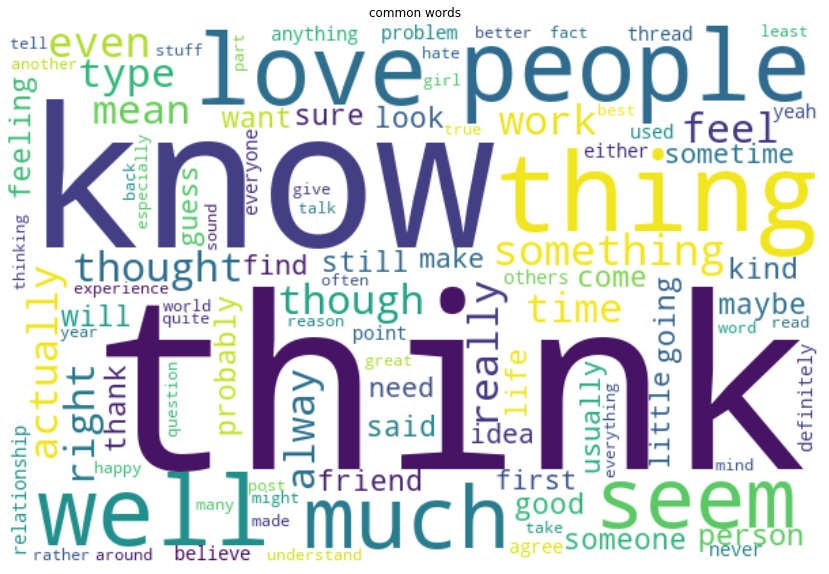

In [43]:
# make stopwords before cleaning the words 
new_text = ''.join(personality_data['clean_posts'])
stopword = set(STOPWORDS)
wordcloud = WordCloud(background_color='white', stopwords=stopword,width=600, height=400, max_words=100, min_word_length=4,repeat=False).generate(new_text)

plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(wordcloud,interpolation='bilinear')
plt.title('common words')

### Feature Engineering
This is one important step in machine learning. Feature engineering is the process of extracting and tranforming features from raw data so they can be used for machine learning models. Here we would need to utilize three feature engineering techniques.
    1. Count vectorizer
    2. Label Encoding 
    3. TF-IDF vectorizer

#### Label Encoding
Label encoding is an encoding technique that convert categorical variables into numerical values and that is what computers understand to build machine learning models. It encodes label into values between 0 and 1.

In [46]:
# Label encoding 
enc_type = LabelEncoder()
personality_data['enc_type'] = enc_type.fit_transform(personality_data['type'])
personality_data

,type,clean_posts,posts,enc_type
0,INFJ,moment sportscenter top ten play prank life ch...,4515,8
1,ENTP,m finding lack post alarming sex boring s posi...,3991,3
2,INTP,good one course say know s blessing curse abso...,2411,11
3,INTJ,dear enjoyed conversation day esoteric gabbing...,1191,10
4,ENTJ,re fired s another silly misconception approac...,5544,2
...,...,...,...,...
8670,ISFP,always think cat fi doms reason website become...,271,13
8671,ENFP,thread already exists someplace heck delete on...,7369,1
8672,INTP,many question thing take purple pill pick winn...,4304,11
8673,INFP,conflicted right now come wanting child honest...,970,9


* We choose label encoding over one-hot encoding to reduce the pre-processing time, and majority due to the fact that there are predefined 16 values under MBTI and assigning unique integer based on alphabetical ordering seems like a viable option
* It appears to be a better technique for dimensionality reduction.

### Counter Vectorization
Counter vectorizer is the process of converting a collection of text documents to vector of tokens and build a vocabulary of known words. It is used to count the number of times each word occurs in the document.

In [60]:
## count vectorizer
# vectorizing the posts for modelling 
# instantiate the vectorier object
count = CountVectorizer(stop_words = set(STOPWORDS))
feature = count.fit_transform(personality_data['clean_posts'])

In [64]:
# view data 
print(f'There are about {feature.shape[1]} in the data for {feature.shape[0]} users')

There are about 88592 in the data for 8675 users


Now, we need to train the data on several algorithms like random forest, XGBoost, decision tree, gradient boosting, multinomial naive bayes,  Bagging classifier, CatBoostClassifier. This is because we want to select the model that gives the best accurate result.

To do this, we would split the data into training and testing set to find the best result

In [66]:
# splitting data into training and testing 
target = personality_data['enc_type']
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.30, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6072, 88592), (2603, 88592), (6072,), (2603,))

## Model building 
1. Random forest classifier
2. Decision Tree classifier
3. Multinomial classifier (naive bayes for multinomial models)
4. XGBoost
5. AdaBoost Classifier
6. Gradient Boosting

##### Random Forest Classifier

In [156]:
def random_forest(x, y):
    random_forest = RandomForestClassifier(n_estimators=500)
    random_forest = random_forest.fit(x, y)
    return random_forest

In [157]:
# instantiate the random forest
randomForest = random_forest(X_train, y_train)
randomForest

RandomForestClassifier(n_estimators=500)

In [161]:
# create a prediction function and reuse for all models
def predict_model(model, x):
    pred = model.predict(x)
    return pred

In [162]:
rf_pred = predict_model(randomForest, X_test)
rf_pred

array([ 9,  9, 11, ...,  9,  8,  9])

In [164]:
# create a dataframe 
# function to write dataframe
def build_dataframe(x, y):
    data = pd.DataFrame({'Actual':x,'predicted':y})
    return data

data = build_dataframe(y_test, rf_pred)
data

,Actual,predicted
0,11,9
1,10,9
2,11,11
3,1,9
4,2,9
...,...,...
2598,8,8
2599,9,9
2600,1,9
2601,3,8


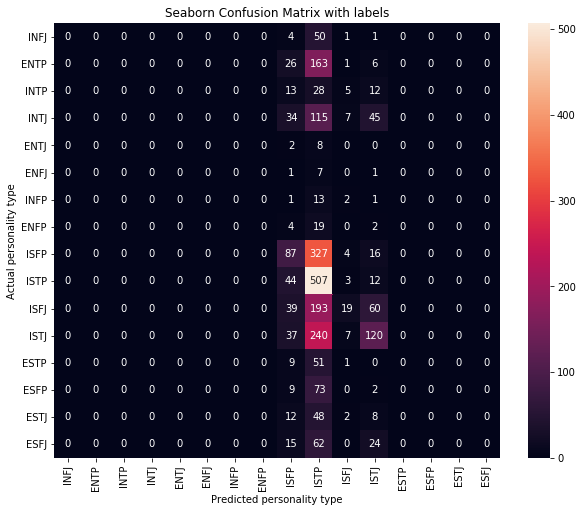

In [178]:
# confusion matrix
def confusion_display(x, y):
    confusionMatrix = confusion_matrix(x, y)
    # plot the confusion matrix
    labels = personality_data.type.unique()
    fig = plt.figure(figsize=(10,8))
    # create a plot for the confusion matrix
    ax = sns.heatmap(confusionMatrix, annot=True, fmt='d')
    # add a title to the figure
    ax.set_title('Seaborn Confusion Matrix with labels')
    # add x label to the figure
    ax.set_xlabel('Predicted personality type')
    # add y label to the figure
    ax.set_ylabel('Actual personality type')
    
    # For the Tick Labels, the labels should be in Alphabetical order
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.xticks(rotation ='vertical')
    plt.yticks(rotation ='horizontal')
#     plt.show()
    
#     return fig

rf = confusion_display(y_test, rf_pred)
rf

In [187]:
def accuracy(x, y):
    Accuracy = round(accuracy_score(x, y)*100,2)
    return Accuracy

rf_accuracy = accuracy(y_test, rf_pred)
rf_accuracy

28.16

In [184]:
def classificationReport(x, y):
    return classification_report(x, y, target_names=labels)

random_report = classificationReport(y_test, rf_pred)
print(report)

              precision    recall  f1-score   support

        INFJ       0.00      0.00      0.00        56
        ENTP       0.00      0.00      0.00       196
        INTP       0.00      0.00      0.00        58
        INTJ       0.00      0.00      0.00       201
        ENTJ       0.00      0.00      0.00        10
        ENFJ       0.00      0.00      0.00         9
        INFP       0.00      0.00      0.00        17
        ENFP       0.00      0.00      0.00        25
        ISFP       0.26      0.20      0.23       434
        ISTP       0.27      0.90      0.41       566
        ISFJ       0.37      0.06      0.10       311
        ISTJ       0.39      0.30      0.34       404
        ESTP       0.00      0.00      0.00        61
        ESFP       0.00      0.00      0.00        84
        ESTJ       0.00      0.00      0.00        70
        ESFJ       0.00      0.00      0.00       101

    accuracy                           0.28      2603
   macro avg       0.08   

##### Decision Tree classifier

In [179]:
# instantiate a decision tree object
def decision_tree(x,y):
    decision_tree = DecisionTreeClassifier(criterion='gini', splitter='best')
    decision_tree = decision_tree.fit(x,y)
    return decision_tree

# a variable for for the tree model
tree = decision_tree(X_train, y_train)

In [180]:
tree

DecisionTreeClassifier()

In [181]:
# make a prediction on a test data
tree_pred = predict_model(tree, X_test)
tree_pred

array([14, 10,  3, ...,  3,  3, 10])

In [182]:
# create a dataframe to view the prediction
result = build_dataframe(y_test, tree_pred)
result

,Actual,predicted
0,11,14
1,10,10
2,11,3
3,1,4
4,2,13
...,...,...
2598,8,9
2599,9,10
2600,1,3
2601,3,3


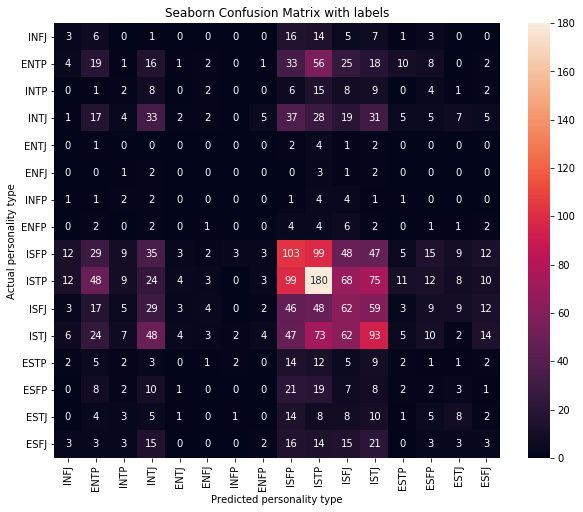

In [185]:
# confusion matrix for decision tree
dt_matrix = confusion_display(y_test, tree_pred)
dt_matrix

In [188]:
# Calculate accuracy for decision tree
dt_accuracy = accuracy(y_test, tree_pred)
dt_accuracy

19.59

In [193]:
# classification report for decision tree
dt_report = classificationReport(y_test, tree_pred)
print(dt_report)

              precision    recall  f1-score   support

        INFJ       0.06      0.05      0.06        56
        ENTP       0.10      0.10      0.10       196
        INTP       0.04      0.03      0.04        58
        INTJ       0.14      0.16      0.15       201
        ENTJ       0.00      0.00      0.00        10
        ENFJ       0.00      0.00      0.00         9
        INFP       0.00      0.00      0.00        17
        ENFP       0.00      0.00      0.00        25
        ISFP       0.22      0.24      0.23       434
        ISTP       0.31      0.32      0.31       566
        ISFJ       0.18      0.20      0.19       311
        ISTJ       0.24      0.23      0.23       404
        ESTP       0.04      0.03      0.04        61
        ESFP       0.03      0.02      0.02        84
        ESTJ       0.15      0.11      0.13        70
        ESFJ       0.04      0.03      0.04       101

    accuracy                           0.20      2603
   macro avg       0.10   

##### XGBoost Classifier

In [189]:
# fit the model
def create_xgbModel(x, y):
    XGboost = XGBClassifier()
    XGboost = XGboost.fit(x, y)
    return XGboost

XgboostModel = create_xgbModel(X_train, y_train)
XgboostModel

[18:51:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [190]:
# make prediction 
XBpred = predict_model(XgboostModel, X_test)
XBpred

array([11, 11, 11, ...,  9,  3,  9])

In [191]:
# create a dataframe to view the prediction
df = build_dataframe(y_test, XBpred)
df

,Actual,predicted
0,11,11
1,10,11
2,11,11
3,1,1
4,2,10
...,...,...
2598,8,8
2599,9,9
2600,1,9
2601,3,3


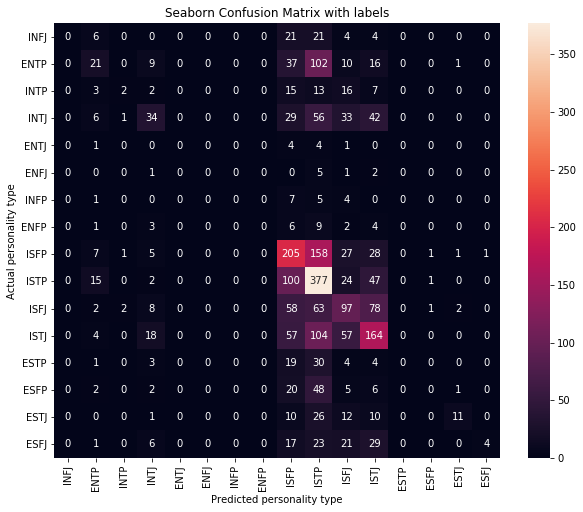

In [192]:
# confusion matrix for XGboost classifier
XG_matrix = confusion_display(y_test, XBpred)
XG_matrix

In [194]:
# Calculate accuracy for XGboost classifier
XGB_accuracy = accuracy(y_test, XBpred)
XGB_accuracy

35.15

In [195]:
# classification report for XGboost classifier 
XGB_report = classificationReport(y_test, XBpred)
print(XGB_report)

              precision    recall  f1-score   support

        INFJ       0.00      0.00      0.00        56
        ENTP       0.30      0.11      0.16       196
        INTP       0.33      0.03      0.06        58
        INTJ       0.36      0.17      0.23       201
        ENTJ       0.00      0.00      0.00        10
        ENFJ       0.00      0.00      0.00         9
        INFP       0.00      0.00      0.00        17
        ENFP       0.00      0.00      0.00        25
        ISFP       0.34      0.47      0.39       434
        ISTP       0.36      0.67      0.47       566
        ISFJ       0.31      0.31      0.31       311
        ISTJ       0.37      0.41      0.39       404
        ESTP       0.00      0.00      0.00        61
        ESFP       0.00      0.00      0.00        84
        ESTJ       0.69      0.16      0.26        70
        ESFJ       0.80      0.04      0.08       101

    accuracy                           0.35      2603
   macro avg       0.24   

##### Gradient Boosting 

In [196]:
def create_model(x, y):
    gradient_boosting = GradientBoostingClassifier(n_estimators=20,max_depth=2, learning_rate=0.2)
    gradient_boosting = gradient_boosting.fit(x, y)
    return gradient_boosting

gradientBoostingModel = create_model(X_train, y_train)
gradientBoostingModel

GradientBoostingClassifier(learning_rate=0.2, max_depth=2, n_estimators=20)

In [197]:
# make predictions 
gradient_pred = predict_model(gradientBoostingModel, X_test)
gradient_pred

array([ 9,  9, 11, ..., 11,  8,  9])

In [198]:
# create a dataframe to view the prediction
df = build_dataframe(y_test, gradient_pred)
df

,Actual,predicted
0,11,9
1,10,9
2,11,11
3,1,1
4,2,10
...,...,...
2598,8,8
2599,9,9
2600,1,11
2601,3,8


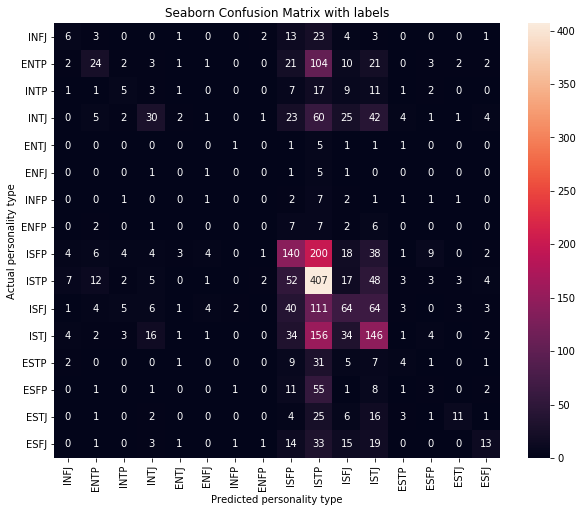

In [199]:
# confusion matrix for gradient boosting
GB_matrix = confusion_display(y_test, gradient_pred)
GB_matrix

In [201]:
# Calculate accuracy for gradient boosting
GB_accuracy = accuracy(y_test, gradient_pred)
GB_accuracy

32.81

In [203]:
gradient_report = classificationReport(y_test, gradient_pred)
print(gradient_report)

              precision    recall  f1-score   support

        INFJ       0.22      0.11      0.14        56
        ENTP       0.39      0.12      0.19       196
        INTP       0.21      0.09      0.12        58
        INTJ       0.40      0.15      0.22       201
        ENTJ       0.00      0.00      0.00        10
        ENFJ       0.07      0.11      0.09         9
        INFP       0.00      0.00      0.00        17
        ENFP       0.00      0.00      0.00        25
        ISFP       0.37      0.32      0.34       434
        ISTP       0.33      0.72      0.45       566
        ISFJ       0.30      0.21      0.24       311
        ISTJ       0.34      0.36      0.35       404
        ESTP       0.17      0.07      0.10        61
        ESFP       0.11      0.04      0.05        84
        ESTJ       0.52      0.16      0.24        70
        ESFJ       0.37      0.13      0.19       101

    accuracy                           0.33      2603
   macro avg       0.24   

##### Multinomial bayes 

In [204]:
def create_model(x, y):
    naive_bayes = MultinomialNB()
    naive_bayes = naive_bayes.fit(x, y)
    return naive_bayes

MNB_model = create_model(X_train, y_train)
MNB_model

MultinomialNB()

In [205]:
# make predictions
MNB_pred = predict_model(MNB_model, X_test)
MNB_pred

array([ 9,  8, 11, ...,  9,  8,  9])

In [207]:
# create a dataframe to view the prediction
df = build_dataframe(y_test, MNB_pred)
df

,Actual,predicted
0,11,9
1,10,8
2,11,11
3,1,8
4,2,9
...,...,...
2598,8,8
2599,9,9
2600,1,9
2601,3,8


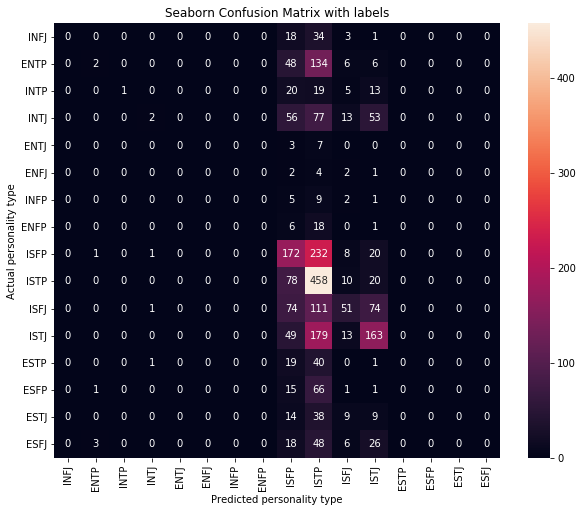

In [208]:
# confusion matrix for naive bayes tree
MNB_matrix = confusion_display(y_test, MNB_pred)
MNB_matrix

In [210]:
# accuracy for naive bayes
MNB_accuracy = accuracy(y_test, MNB_pred)
MNB_accuracy

32.62

In [216]:
# print classification reportfor naive bayes
MNB_report = classificationReport(y_test, MNB_pred)
print(MNB_report)

              precision    recall  f1-score   support

        INFJ       0.00      0.00      0.00        56
        ENTP       0.29      0.01      0.02       196
        INTP       1.00      0.02      0.03        58
        INTJ       0.40      0.01      0.02       201
        ENTJ       0.00      0.00      0.00        10
        ENFJ       0.00      0.00      0.00         9
        INFP       0.00      0.00      0.00        17
        ENFP       0.00      0.00      0.00        25
        ISFP       0.29      0.40      0.33       434
        ISTP       0.31      0.81      0.45       566
        ISFJ       0.40      0.16      0.23       311
        ISTJ       0.42      0.40      0.41       404
        ESTP       0.00      0.00      0.00        61
        ESFP       0.00      0.00      0.00        84
        ESTJ       0.00      0.00      0.00        70
        ESFJ       0.00      0.00      0.00       101

    accuracy                           0.33      2603
   macro avg       0.19   

##### Adaboost Classifier

In [211]:
def create_model(x,y):
    ada_boost = AdaBoostClassifier(n_estimators=20, learning_rate=0.2)
    ada_boost = ada_boost.fit(x, y)
    return ada_boost

adaBoostModel =create_model(X_train, y_train)
adaBoostModel

AdaBoostClassifier(learning_rate=0.2, n_estimators=20)

In [212]:
# make predictions
ada_pred = predict_model(adaBoostModel, X_test)
ada_pred

array([ 9, 11,  9, ...,  9,  9,  9])

In [213]:
# create a dataframe to view the prediction
df = build_dataframe(y_test, ada_pred)
df

,Actual,predicted
0,11,9
1,10,11
2,11,9
3,1,9
4,2,9
...,...,...
2598,8,9
2599,9,9
2600,1,9
2601,3,9


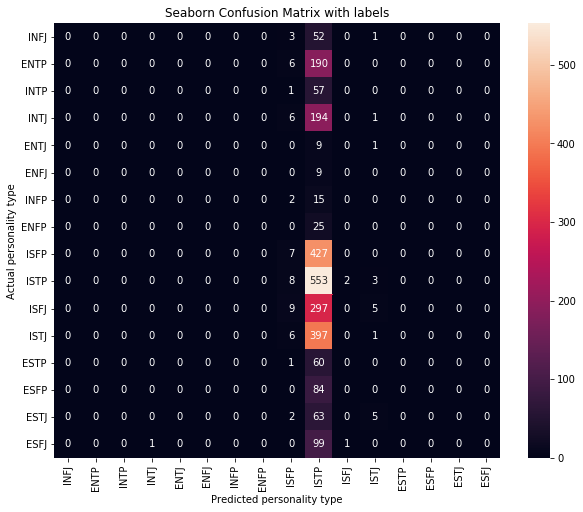

In [214]:
# confusion matrix for adaboost classifier
ada_matrix = confusion_display(y_test, ada_pred)
ada_matrix

In [215]:
# accuracy for ada boost
ada_accuracy = accuracy(y_test, ada_pred)
ada_accuracy

21.55

In [ ]:
# print classification reportfor naive bayes
MNB_report = classificationReport(y_test, MNB_pred)
print(MNB_report)

### Model Selection

In [229]:
# create a dataframe
model_accuracy = {
    'Random Forest': rf_accuracy,
    'Decision Tree': dt_accuracy,
    'XGBoost': XGB_accuracy,
    'Gradient Boosting': GB_accuracy,
    'AdaBoost Classifier': ada_accuracy,
    'Multinomial naive bayes':MNB_accuracy
}
result = pd.DataFrame.from_dict(model_accuracy, orient='index', columns=['Accuracy'])
result

,Accuracy
Random Forest,28.16
Decision Tree,19.59
XGBoost,35.15
Gradient Boosting,32.81
AdaBoost Classifier,21.55
Multinomial naive bayes,32.62


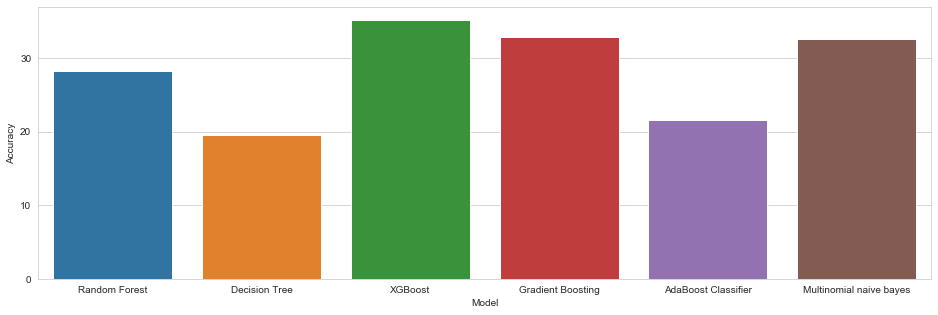

In [230]:
sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.title('Model Comparison')
plt.ylabel("Accuracy")
plt.xlabel("Model")
sns.barplot(x=list(model_accuracy.keys()), y=list(model_accuracy.values()))
plt.show()

From the plot, all models didnt perform well on the dataset because of numerous reasons. Firstly, the data is an not balanced and we need to ensure almost equal dataset should be passed for machine learning. Secondly, there was no hyperparameter tuning. To overcome this work in the future, I would like to explore the following:
    1. Balance the dataset
    2. Use deep learning method
    3. Focus on recall and precision.
    
Overall, all the models performed poorly on the data but XGBoost was better than the rest.
    